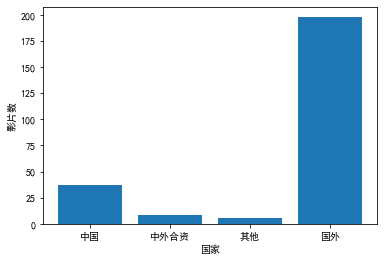

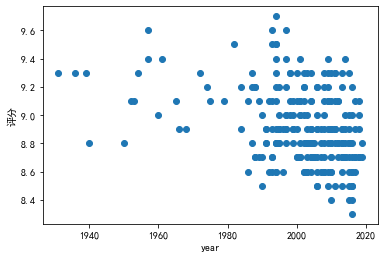

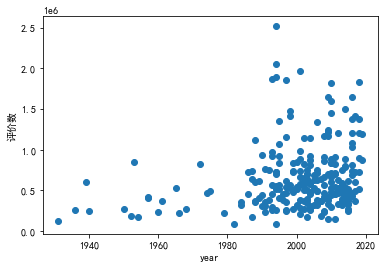

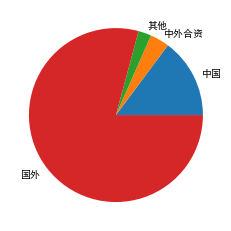

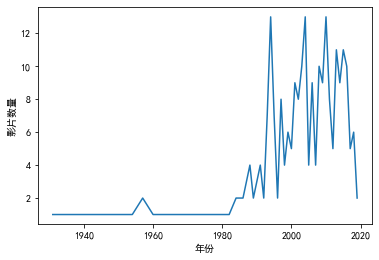

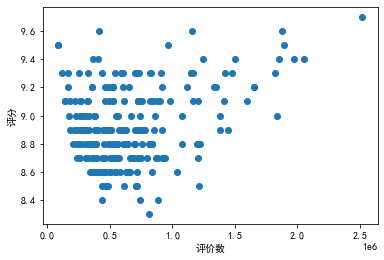

爬取完毕！


In [498]:
# -*- codeing = utf-8 -*-
from bs4 import BeautifulSoup  # 网页解析，获取数据
import re  # 正则表达式，进行文字匹配`
import urllib.request, urllib.error  # 制定URL，获取网页数据
import xlwt  # 进行excel操作
from sklearn import linear_model
import pymongo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba

def main():
    baseurl = "https://movie.douban.com/top250?start="  #要爬取的网页链接
    # 1.爬取网页
    datalist = getData(baseurl)
    savepath = "豆瓣电影Top250.xls"    #当前目录新建XLS，存储进去
    # 2.保存数据
    saveData(datalist,savepath)      #保存数据到Excel
    saveIn_mongodb(datalist)         #保存数据到mongoDB
    #  3.处理数据
    data=analyzeData('D:/豆瓣电影Top250.xls')#对相关信息进行切割分类
    dataVisualization(data)#对信息进行可视化分析


#保存数据到Mongodb数据库
def saveIn_mongodb(datalist):
    client=pymongo.MongoClient('localhost',27017)
    book=client['film']
    sheet=book['sheet_film']
    
    col = ("电影详情链接","图片链接","影片中文名","影片外国名","评分","评价数","概况","相关信息")
    for i in range(0,250):
        data = datalist[i]
        dic=dict(zip(col,datalist[i][0:8]))
        sheet.insert_one(dic)


    
if __name__ == "__main__":  # 当程序执行时
    # 调用函数
     main()
    # init_db("movietest.db")
     print("爬取完毕！")



In [ ]:
def dataVisualization(data):
    dataVisualization_1(data)
    dataVisualization_2(data)
    dataVisualization_3(data)
    dataVisualization_4(data)
    dataVisualization_5(data)
    dataVisualization_6(data)
    return

In [390]:
def dataVisualization_1(data):
    #中国生产电影占比柱状图
    nation_count_s = data.groupby(by='nation')['影片中文名'].nunique()
    plt.bar(nation_count_s.index,nation_count_s.values)
    plt.ylabel('影片数')
    plt.xlabel('国家')
    plt.show()
    return

In [391]:
def dataVisualization_2(data):
    #生产年份与评分的相关关系散点图
    plt.scatter(data['year'],data['评分'])
    plt.ylabel('评分')
    plt.xlabel('year')
    plt.show()
    return

In [392]:
def dataVisualization_3(data):
    #生产年份与评价数的相关关系散点图
    plt.scatter(data['year'],data['评价数'])
    plt.ylabel('评价数')
    plt.xlabel('year')
    plt.show()
    return

In [445]:
def dataVisualization_4(data):
    #中国生产电影占比饼状图
    nation_count_s = data.groupby(by='nation')['影片中文名'].nunique()
    plt.pie(nation_count_s,labels=['中国','中外合资','其他','国外'],)
    plt.show()
    return

In [443]:
def dataVisualization_5(data):
    #影片数量和年份的折线图
    nation_count_s = data.groupby(by='year')['影片中文名'].nunique()
    plt.plot(nation_count_s.index,nation_count_s.values)
    plt.ylabel('影片数量')
    plt.xlabel('年份')
    plt.show()
    return

In [497]:
def dataVisualization_6(data):
    #评价数和评分的相关关系
    plt.scatter(data['评价数'],data['评分'])
    plt.ylabel('评分')
    plt.xlabel('评价数')
    plt.show()
    #回归分析，未完。。。。
    return

In [139]:
findLink = re.compile(r'<a href="(.*?)">')  # 创建正则表达式对象，标售规则   影片详情链接的规则
findImgSrc = re.compile(r'<img.*src="(.*?)"', re.S)
findTitle = re.compile(r'<span class="title">(.*)</span>')
findRating = re.compile(r'<span class="rating_num" property="v:average">(.*)</span>')
findJudge = re.compile(r'<span>(\d*)人评价</span>')
findInq = re.compile(r'<span class="inq">(.*)</span>')
findBd = re.compile(r'<p class="">(.*?)</p>', re.S)

In [352]:
#处理数据
def analyzeData(datafile):
    plt.rcParams['font.sans-serif'] = [u'SimHei'] ##显示中文，设置字体
    plt.rcParams['axes.unicode_minus'] = False ##显示符号
    df = pd.DataFrame(pd.read_excel('D:\豆瓣电影Top250.xls'))
    df.head(10)
    data = df.drop_duplicates(inplace = False)
    #print(data.head(10))
    subtitle=[]
    for each in data['相关信息']:
        each= re.sub(r'主演.*\.','',each)
        k=list(jieba.cut(each)) ##搜索引擎模式
        subtitle.append(k)
    data['subtitle']=subtitle 

    #print(subtitle[0])
    
    #导演列
    director=[]
    for each in data['subtitle']:
        k=''
        for each0 in each :
            k=k+each0
            if each0=='\xa0':
                k=k.lstrip('导演: ')
                k=k.lstrip(' ')
                k=k.rstrip('\xa0')
                k = re.sub('\/','',k)
                director.append(k)
                break
    data['director']=director
    #print(data['director'])
    
    #电影年份
    year=[]
    for each in data['subtitle']:
        for each0 in each:
            if re.findall(r"\d+\.?\d*",each0):
                str_list = ''.join(re.findall(r"\d+\.?\d*",each0)) 
                year.append(int(str_list))
                
                break
    data['year']=year
    #print(data['year'].head(10))
    
    #分类
    china="""中国 中国香港 中国台湾 中国大陆 台湾 香港 大陆"""
    foreign="""国外 美国 德国 英国 法国 瑞士 印度 意大利 日本 加拿大 新西兰 韩国"""
    dcatg_china={}
    dcatg_foreign={}
    catg_china=china.split('\n')
    catg_foreign=foreign.split('\n')
    for i in catg_china:
        main_cat=i.strip().split(' ')[0]
        o_cat=i.strip().split(' ')[1:len(i)]
        for j in o_cat:
            dcatg_china[j]=(main_cat)
    main_cat=[]
    for i in catg_foreign:
        main_cat=i.strip().split(' ')[0]
        o_cat=i.strip().split(' ')[1:len(i)]
        for j in o_cat:
            dcatg_foreign[j]=(main_cat)
    
#     print(dcatg_china)
#     print(dcatg_foreign)
    
    #国家
    nation=[]
    for i in range(data.shape[0]):#遍历data的每一行数据
        exist1 = False
        exist2 = False
        for j in data['subtitle'][i]:#遍历subtitle列的每一个元素（列表）中的元素
            if j in dcatg_china:
                exist2 = True  
            if j in dcatg_foreign:#如果j被包含在dcatg字典中的key
                exist1 = True
        
        if exist1 and exist2:
            nation.append('中外合资')
        elif exist1 and (not exist2):
            nation.append('国外')
        elif (not exist1) and exist2:
            nation.append('中国')  
        elif not exist1 and not exist2:
            nation.append('其他')
    data['nation']=nation
    return data

In [212]:
# 爬取网页
def getData(baseurl):
    datalist = []  #用来存储爬取的网页信息
    for i in range(0, 10):  # 调用获取页面信息的函数，10次
        url = baseurl + str(i * 25)
        html = askURL(url)  # 保存获取到的网页源码
        # 2.逐一解析数据
        soup = BeautifulSoup(html, "html.parser")
        for item in soup.find_all('div', class_="item"):  # 查找符合要求的字符串
            data = []  # 保存一部电影所有信息
            item = str(item)
            link = re.findall(findLink, item)[0]  # 通过正则表达式查找
            data.append(link)
            imgSrc = re.findall(findImgSrc, item)[0]
            data.append(imgSrc)
            titles = re.findall(findTitle, item)
            if (len(titles) == 2):
                ctitle = titles[0]
                data.append(ctitle)
                #otitle = titles[1].replace("/", "")  #消除转义字符
                otitle = titles
                data.append(otitle)
            else:
                data.append(titles[0])
                data.append(' ')
            rating = re.findall(findRating, item)[0]
            data.append(rating)
            judgeNum = re.findall(findJudge, item)[0]
            data.append(judgeNum)
            inq = re.findall(findInq, item)
            if len(inq) != 0:
                #inq = inq[0].replace("。", "")
                data.append(inq)
            else:
                data.append(" ")
            bd = re.findall(findBd, item)[0]
            bd = re.sub('<br(\s+)?/>(\s+)?', "", bd)
#             bd = re.sub('/', "", bd)
            data.append(bd.strip())
            datalist.append(data)

    return datalist

In [ ]:
# 得到指定一个URL的网页内容
def askURL(url):
    head = {  # 模拟浏览器头部信息，向豆瓣服务器发送消息
        "User-Agent": "Mozilla / 5.0(Windows NT 10.0; Win64; x64) AppleWebKit / 537.36(KHTML, like Gecko) Chrome / 80.0.3987.122  Safari / 537.36"
    }
    # 用户代理，表示告诉豆瓣服务器，我们是什么类型的机器、浏览器（本质上是告诉浏览器，我们可以接收什么水平的文件内容）

    request = urllib.request.Request(url, headers=head)
    html = ""
    try:
        response = urllib.request.urlopen(request)
        html = response.read().decode("utf-8")
    except urllib.error.URLError as e:
        if hasattr(e, "code"):
            print(e.code)
        if hasattr(e, "reason"):
            print(e.reason)
    return html

In [ ]:
# 保存数据到表格
def saveData(datalist,savepath):
    print("save.......")
    book = xlwt.Workbook(encoding="utf-8",style_compression=0) #创建workbook对象
    sheet = book.add_sheet('豆瓣电影Top250', cell_overwrite_ok=True) #创建工作表
    col = ("电影详情链接","图片链接","影片中文名","影片外国名","评分","评价数","概况","相关信息")
    for i in range(0,8):
        sheet.write(0,i,col[i])  #列名
    for i in range(0,250):
        # print("第%d条" %(i+1))       #输出语句，用来测试
        data = datalist[i]
        for j in range(0,8):
            sheet.write(i+1,j,data[j])  #数据
    book.save(savepath) #保存